In [127]:
import numpy as np
import pandas as pd
#import numpy and pandas libraries

In [128]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

#import necessary libraries in Pytorch and matplotlib

In [165]:
dataset_folder = "../../dataset/"
oil_df = pd.read_csv(dataset_folder + 'oil.csv')
coin_df = pd.read_csv(dataset_folder + 'coin.csv')
microsoft_df = pd.read_csv(dataset_folder + 'microsoft.csv')
sp500_df = pd.read_csv(dataset_folder + 'sp500.csv')
artificial1_df = pd.read_csv(dataset_folder + 'Artificial_trend.csv')
artificial2_df = pd.read_csv(dataset_folder + 'Artificial_trend1.csv')

In [130]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#we import MinMaxScaler function from sklearn to scale our dataset and also make a instance of that

In [131]:
def format_train_test (batch_size, data, percent, num_predicts, column_i):
    """
    Here is the function to make train set, test set, and label for each of them from the dataframe.We first want to see how many
    We want to find the percent of data used for train set. Then, we find length of train data so that it could divisible by batch 
    size. Then we scale the dataset and make train set and label for each by iterating through the dataset until and make them lag
    by number of predict steps we want until we have desired amount of data for train process. Then, we find the length for test
    set and we repeat the same process as forming train set and its label.

    Parameters
    ----------
    batch_size : int
        Num of batch size split
    data : DataFrame
        The dataframe that is needed
    percent : double
        Percentage split between train and test. e.g. 0.2 means 80% train and 20% test
    num_predicts : int
        Nume of predictions
    column_i : 
        The column in the data that you want to make train test set from
    """

    # prepare train data
    length_train = int(data.shape[0]*(1-percent))
    a1 = length_train//batch_size
    length_train = batch_size*a1    # get length of training
    train_data = data.iloc[:, column_i:column_i+1].values    # get desired value columns
    train_data = scaler.fit_transform(train_data)   # 0-1 scale data
    # splitting up data to train and label
    train_set = []
    train_label = []
    for i in range(length_train):
        train_set.append(train_data[i:i + num_predicts])
        train_label.append(train_data[i + num_predicts:i + 2*num_predicts])
    
    # prepare test data
    length_test = int(data.shape[0] - length_train - 4*num_predicts)
    a2 = length_test//batch_size
    length_test = int(batch_size*a2) 
    test = data.iloc[:, column_i:column_i+1].values
    test = scaler.fit_transform(test)
    test_data = test[length_train + 2*num_predicts:length_train + length_test + 4*num_predicts]
    test_set = []
    test_label = []
    for j in range(length_test):
        test_set.append(test_data[j:j + num_predicts])
        test_label.append(test_data[j + num_predicts:j + 2*num_predicts])
    
    train_set = np.reshape(np.array(train_set), (np.array(train_set).shape[0], np.array(train_set).shape[1], 1))
    train_label = np.reshape(np.array(train_label), (np.array(train_label).shape[0], np.array(train_label).shape[1],1))
    test_set = np.reshape(np.array(test_set) ,(np.array(test_set).shape[0], np.array(test_set).shape[1], 1))
    test_label = np.reshape(np.array(test_label), (np.array(test_label).shape[0], np.array(test_label).shape[1],1))
    
    return train_set, train_label, test_set, test_label, length_test


In [132]:
coin_df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [134]:
class biRNN_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2, batch_size, num_layers=2):
        super(biRNN_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.batch_size = batch_size
        self.num_layers = num_layers

        # padding first linear layer
        # self.first_linear = nn.Linear(self.input_dim, self.input_dim)

        # two biRNN layers
        self.bi_rnn1 = nn.RNN(
                            input_size=self.input_dim,
                            hidden_size=self.hidden_dim1,
                            num_layers=self.num_layers,
                            batch_first=True,
                            bidirectional=True
                            )

        # dense layer for prediction
        self.last_linear = nn.Linear(self.hidden_dim2*2, self.output_dim)

    def forward(self, x, hidden_state):
        # s0 = self.first_linear(x)
        s1, self.hidden = self.bi_rnn1(x, hidden_state)
        return self.last_linear(s1)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers * 2, batch_size, self.hidden_dim1).zero_()
        return hidden
        # return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1),
                # torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1))

In [135]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device
# we check for the availablibility of GPU to use for training

device(type='cuda', index=0)

In [136]:
model = biRNN_model(1,5,5,5,64)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#we make model, upload it to GPU, make CrossEntropy loss instance as long as the Adam optimizer with learning rate of 0.001

In [137]:
print(model) #print the model summary

biRNN_model(
  (bi_rnn1): RNN(1, 5, num_layers=2, batch_first=True, bidirectional=True)
  (last_linear): Linear(in_features=10, out_features=5, bias=True)
)


In [138]:
def train_test(model, train_tensor, test_tensor, criterion, optimizer, device, batch_size, iterations):
    tr = []
    te = []
    predict = []
    values = []

    # reset parameters
    for layer in model.children():
        layer.reset_parameters()

    # loop through epochs
    for i in range(iterations):
        h0 = model.init_hidden(batch_size)    # initialize parameters
        h = h0.to(device)   # push parameters to device

        for (x,y) in train_tensor:
            x, y = x.to(device), y.to(device)
            y_hat = model(x.float(), h)
            loss = criterion(y_hat, y.float())
            optimizer.zero_grad()
            h = h.detach()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            h01 = model.init_hidden(batch_size)
            h1 = h01.to(device)
            lost_val = 0

            for (x1, y1) in test_tensor:
                x1, y1 = x1.to(device), y1.to(device)
                y_hat1 = model(x1.float(), h1)
                loss1 = criterion(y_hat1, y1.float())
                lost_val += loss1.item()
                h1 = h1.detach()
                if i == (iterations-1):
                    predict.append(y_hat1)
                    values.append(y1)
                
            lost_val /= len(x1)
            tr.append(loss.item())
            te.append(lost_val)
            print(f"Iteration {i}\n********************")
            print('The loss for train is: ',loss.item())
            print('The loss for test is: ',lost_val)
             
            for j in range(len(predict)):
                predict[j] = predict[j].cpu().numpy()
                values[j] = values[j].cpu().numpy()


    return i, tr, te, np.array(predict).reshape(-1)[::5], np.array(values).reshape(-1)
#Here we create function to do the training and validation process. We iterate through number of epochs, make initial state for model
#and iterate through each data batch to do prediction, compute the loss and do backward propagation to improve the parameters. In
#the same epoch, I also apply the model to make prediction on test dataset to keep track of model performace more closely. I also
#print iteration round, train loss, and test loss. I also return them to do some plots later.

In [ ]:
def plot_predictions(predict, values):
    plt.figure(figsize=(14,10))
    plt.plot(predict, "-o", color="g", label="Predicted")
    plt.plot(values, color="b", label="Actual")
    plt.ylabel('Bitcoin price')
    plt.xlabel('Time Points')
    plt.legend()

def plot_tr_te(iterations,tr,te,title):
    t = np.arange(0,iterations+1)
    y1 = np.array(tr)
    y2 = np.array(te)
    plt.figure(figsize=(6, 4))
    plt.title('Plot of train and test loss vs iterations for '+title)
    plt.plot(t, y1)
    plt.plot(t, y2)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(["train", "test"])

# Artificial Dataset 1

In [169]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=artificial1_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [170]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.04091467335820198
The loss for test is:  0.02532607979082968
Iteration 1
********************
The loss for train is:  0.01748264580965042
The loss for test is:  0.013990227416798007
Iteration 2
********************
The loss for train is:  0.0157187357544899
The loss for test is:  0.012159325429820456
Iteration 3
********************
The loss for train is:  0.01787850633263588
The loss for test is:  0.011749871388019528
Iteration 4
********************
The loss for train is:  0.016111139208078384
The loss for test is:  0.008356453785381746
Iteration 5
********************
The loss for train is:  0.0022471421398222446
The loss for test is:  0.0016205739448196255
Iteration 6
********************
The loss for train is:  0.0010104053653776646
The loss for test is:  0.0007996797530722688
Iteration 7
********************
The loss for train is:  0.000963726022746414
The loss for test is:  0.0006535467500725645
Iteration 8
*************

In [171]:
plot_predictions(predict, values)

NameError: name 'plot_predictions' is not defined

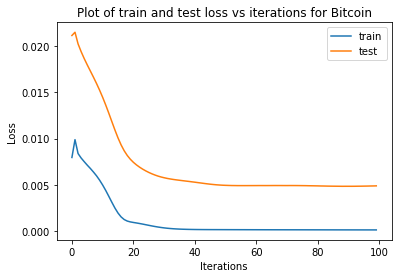

In [ ]:
plot_tr_te(iterations,tr,te,'Bitcoin')

In [167]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=artificial1_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [168]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.00880697462707758
The loss for test is:  0.007007696069194935
Iteration 1
********************
The loss for train is:  0.004496564622968435
The loss for test is:  0.004276554576790659
Iteration 2
********************
The loss for train is:  0.002317882375791669
The loss for test is:  0.00160380460874876
Iteration 3
********************
The loss for train is:  0.001080426387488842
The loss for test is:  0.0008267480834547314
Iteration 4
********************
The loss for train is:  0.0008116075769066811
The loss for test is:  0.0007117399609342101
Iteration 5
********************
The loss for train is:  0.000739227223675698
The loss for test is:  0.0006514953465739381
Iteration 6
********************
The loss for train is:  0.0007004510262049735
The loss for test is:  0.0006023979904057342
Iteration 7
********************
The loss for train is:  0.0006721568061038852
The loss for test is:  0.000560867864805914
Iteration 8
*******

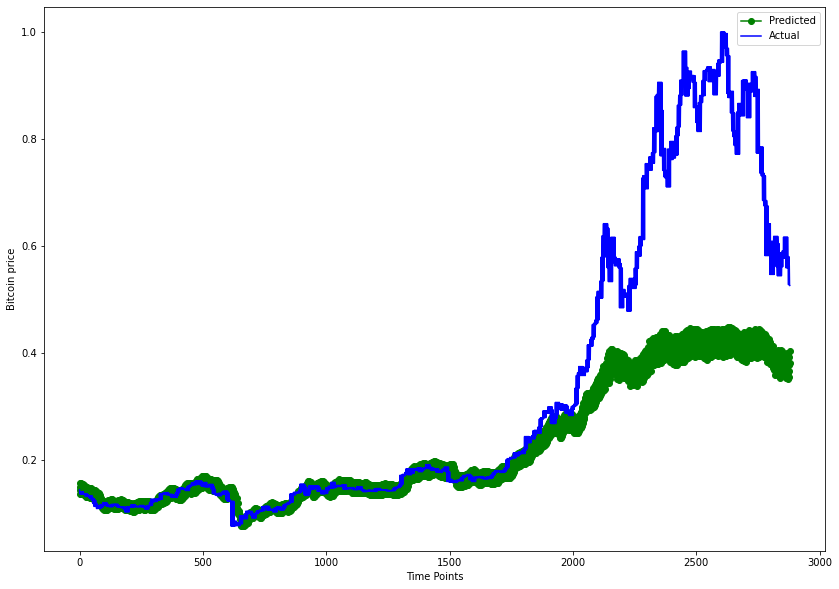

In [ ]:
plot_predictions(predict, values)

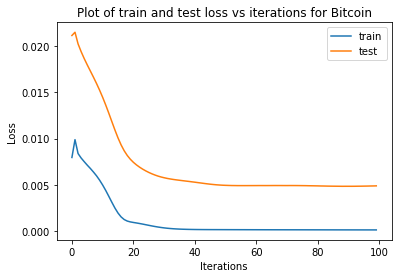

In [ ]:
plot_tr_te(iterations,tr,te,'Bitcoin')

# Bitcoin

In [ ]:
train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=coin_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=7
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

#we then make train, test sets, and their labels. Then we convert them to torch tensors and make torch dataset and use DataLoader to 
#to make data ready for training and testing. Here batch size is 64, percent of test set is 0.2 and 5 predictions steps

In [139]:
iterations, tr, te, predict, values = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,64,100)

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The loss for train is:  0.007957507856190205
The loss for test is:  0.02114212841115659
Iteration 1
********************
The loss for train is:  0.009882403537631035
The loss for test is:  0.021493097592610866
Iteration 2
********************
The loss for train is:  0.008380691520869732
The loss for test is:  0.020232776150805876
Iteration 3
********************
The loss for train is:  0.007898448966443539
The loss for test is:  0.01939538763690507
Iteration 4
********************
The loss for train is:  0.007503290195018053
The loss for test is:  0.018646388103661593
Iteration 5
********************
The loss for train is:  0.007123831193894148
The loss for test is:  0.017958351756533375
Iteration 6
********************
The loss for train is:  0.006769783794879913
The loss for test is:  0.01730037287779851
Iteration 7
********************
The loss for train is:  0.006386719178408384
The loss for test is:  0.016639844794553937
Iteration 8
***************

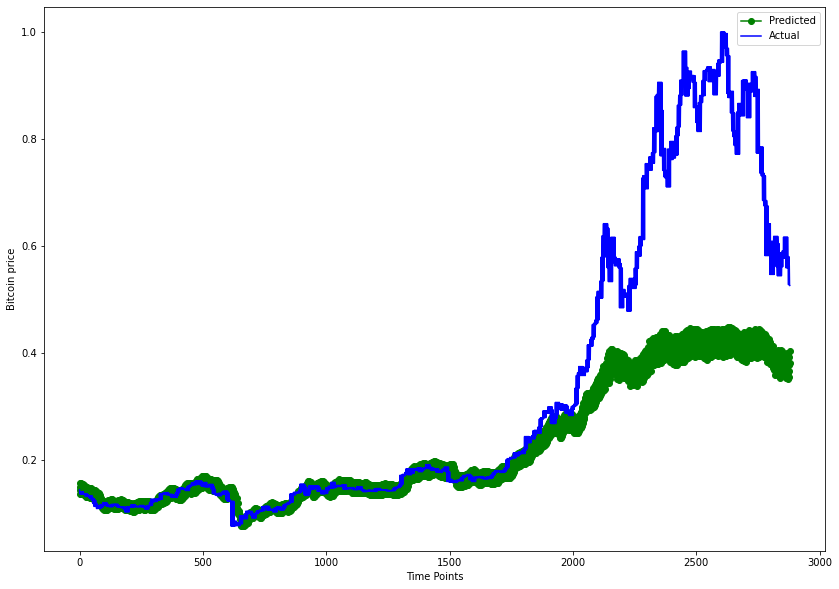

In [154]:
plot_predictions(predict, values)

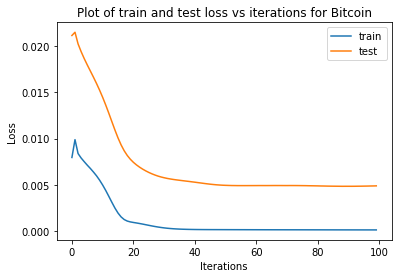

In [156]:
plot_tr_te(iterations,tr,te,'Bitcoin')

In [161]:
train_set, train_label, test_set, test_label = format_train_test(batch_size=64,
                                                                data=oil_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=1
                                                                )

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

ValueError: could not convert string to float: '.'

In [ ]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

Iteration 0
********************
The loss for train is:  1.563568115234375
The loss for test is:  0.09736838191747665
Iteration 1
********************
The loss for train is:  1.389528512954712
The loss for test is:  0.08591794781386852
Iteration 2
********************
The loss for train is:  1.0368711948394775
The loss for test is:  0.06330237910151482
Iteration 3
********************
The loss for train is:  0.6223870515823364
The loss for test is:  0.03777605574578047
Iteration 4
********************
The loss for train is:  0.3518458604812622
The loss for test is:  0.02143275737762451
Iteration 5
********************
The loss for train is:  0.2058582752943039
The loss for test is:  0.01260895561426878
Iteration 6
********************
The loss for train is:  0.12798206508159637
The loss for test is:  0.007911790744401515
Iteration 7
********************
The loss for train is:  0.0859491378068924
The loss for test is:  0.0053782869363203645
Iteration 8
********************
The loss for 

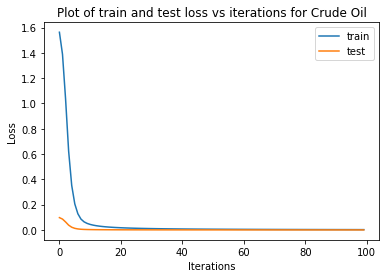

In [ ]:
plot_tr_te(iterations,tr,te,'Crude Oil')

In [164]:
train_set, train_label, test_set, test_label, length = format_train_test(64,artificial1_df,0.2,5,1)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

ValueError: too many values to unpack (expected 4)

In [ ]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

Iteration 0
********************
The loss for train is:  0.7974730730056763
The loss for test is:  0.2690786439925432
Iteration 1
********************
The loss for train is:  0.15427502989768982
The loss for test is:  0.05232929880730808
Iteration 2
********************
The loss for train is:  0.0517512746155262
The loss for test is:  0.01769614889053628
Iteration 3
********************
The loss for train is:  0.02951672114431858
The loss for test is:  0.010141620616195723
Iteration 4
********************
The loss for train is:  0.019309522584080696
The loss for test is:  0.006643328146310523
Iteration 5
********************
The loss for train is:  0.013965299353003502
The loss for test is:  0.004818487432203256
Iteration 6
********************
The loss for train is:  0.010756227187812328
The loss for test is:  0.0037146804825169966
Iteration 7
********************
The loss for train is:  0.00863728392869234
The loss for test is:  0.002982218313263729
Iteration 8
********************
T

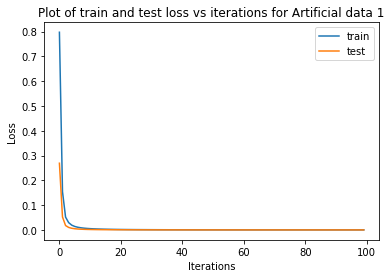

In [ ]:
plot_tr_te(iterations,tr,te,'Artificial data 1')

In [ ]:
train_set, train_label, test_set, test_label = format_train_test(64,microsoft_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [ ]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

Iteration 0
********************
The loss for train is:  1.4878060817718506
The loss for test is:  0.11494661122560501
Iteration 1
********************
The loss for train is:  1.0617077350616455
The loss for test is:  0.08044308237731457
Iteration 2
********************
The loss for train is:  0.5427191853523254
The loss for test is:  0.040229037404060364
Iteration 3
********************
The loss for train is:  0.2573263645172119
The loss for test is:  0.019208662677556276
Iteration 4
********************
The loss for train is:  0.13988342881202698
The loss for test is:  0.010543433483690023
Iteration 5
********************
The loss for train is:  0.0896291434764862
The loss for test is:  0.006836221786215901
Iteration 6
********************
The loss for train is:  0.0648525133728981
The loss for test is:  0.004968427121639252
Iteration 7
********************
The loss for train is:  0.050568193197250366
The loss for test is:  0.0038909000577405095
Iteration 8
********************
The l

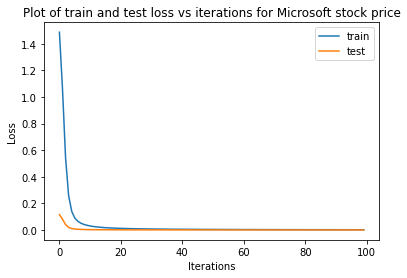

In [ ]:
plot_tr_te(iterations,tr,te,'Microsoft stock price')

In [ ]:
train_set, train_label, test_set, test_label = format_train_test(64,sp500_df,0.2,5)

train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

train = TensorDataset(train_set, train_label)
train_tensor = DataLoader(train, batch_size = 64, shuffle=True)

test = TensorDataset(test_set, test_label)
test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

In [ ]:
iterations, tr, te, predict = train_test(model,train_tensor,test_tensor,criterion,optimizer,device,5,100)

Iteration 0
********************
The loss for train is:  1.3744409084320068
The loss for test is:  0.10612084716558456
Iteration 1
********************
The loss for train is:  0.9078464508056641
The loss for test is:  0.06923385988920927
Iteration 2
********************
The loss for train is:  0.5240486264228821
The loss for test is:  0.03994436375796795
Iteration 3
********************
The loss for train is:  0.30335861444473267
The loss for test is:  0.023142720106989145
Iteration 4
********************
The loss for train is:  0.18560020625591278
The loss for test is:  0.014205004554241896
Iteration 5
********************
The loss for train is:  0.12659934163093567
The loss for test is:  0.009736060164868832
Iteration 6
********************
The loss for train is:  0.09420038759708405
The loss for test is:  0.00726956594735384
Iteration 7
********************
The loss for train is:  0.07410630583763123
The loss for test is:  0.0057329339906573296
Iteration 8
********************
The l

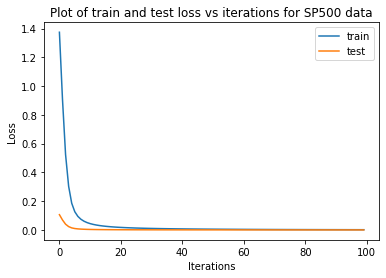

In [ ]:
plot_tr_te(iterations,tr,te,'SP500 data')

In [ ]:
def plot_test(test_set,predict,test_length,num_predicts):
    a = np.array(predict)
    a = a[:,:,:,0]
    a = np.reshape(a,(a.shape[0]*a.shape[1],a.shape[2]))
    a = scaler.inverse_transform(a)
    a = np.reshape(a,(-1,1))
    b = test_set[:,:,0]
    b = scaler.inverse_transform(b)
    b = np.reshape(b,(-1,1))
    #temp = []
    
    print(a.shape)
    print(b.shape)
    #for i in range(0,test_length):
        #temp.append(a[i,num_predicts-5])
    #temp = np.array(temp)
    #temp = np.reshape(temp,(temp.shape[0],1))
    #print(temp.shape)
    plt.plot(a)
    plt.plot(b)

In [ ]:
plot_test(test_set,predict,length_test,5)

In [ ]:
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()
criterion3 = nn.NLLLoss()

In [ ]:
#we need to try with three other loss functions as well